## This notebook compares the reweighted distribution for observles between the truth value for aLund (0.80) and the (incorrect) fit value (0.59).

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
# standard library imports
from __future__ import absolute_import, division, print_function

import keras
import keras.backend as K
import tensorflow as tf

# standard numerical library imports
import numpy as np
import scipy as sp

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split, remap_pids, to_categorical

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22) 
rc('xtick', labelsize=15) 
rc('ytick', labelsize=15) 
rc('legend', fontsize=15)

# Load Data

## Utilities

In [4]:
# normalize pT and center (y, phi)
def normalize(x):
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

In [5]:
def preprocess_data(X):
    for x in X:
        normalize(x)
    
    # Remap PIDs to unique values in range [0,1]
    remap_pids(X, pid_i=3)
    return X

# Build Model

In [6]:
# network architecture parameters
Phi_sizes = (100,100, 128)
F_sizes = (100,100, 100)

dctr = PFN(input_dim=7, 
           Phi_sizes=Phi_sizes, F_sizes=F_sizes,
           summary=False)

# Load Model

In [7]:
# load model from saved file
dctr.model.load_weights('./saved_models/DCTR_ee_dijets_1D_aLund.h5')

# Validation

## Load Datasets

In [8]:
# Path to downloaded data from Zenodo
data_dir = '/data0/users/aandreassen/zenodo/'

test_dataset_0 = np.load(data_dir+'test1D_default.npz')
test_dataset_1 = np.load(data_dir+'test1D_aLund.npz')

In [9]:
# Define labels for legends
label_0 = r'aLund=0.68' # default value

label_1 = r'aLund=0.80' # truth value

label_2 = r'aLund=0.59' # (incorrect) fit value

pythia_text = r'\textsc{Pythia 8}' + '\n' + r'$e^+e^- \to Z \to $ dijets' +'\n'+ r"anti-$k_{\mathrm{T}}$, $R=0.8$"
def make_legend():
    ax = plt.gca()
    leg = ax.legend(frameon=False)
    leg.set_title(pythia_text, prop={'size':14})
    leg._legend_box.align = "left"
    plt.tight_layout()

## Get test data

In [10]:
# Load test datasets
X0_test = preprocess_data(test_dataset_0['jet'][:,:,:4])
X1_test = preprocess_data(test_dataset_1['jet'][:,:,:4])

## Define reweighting function

In [11]:
def reweight(inputs, val): #from NN (DCTR)
    
    x  = tf.convert_to_tensor(inputs) 
    #Reshaping to correct format
    #x = tf.gather(x, np.arange(batch_size)) #for training
    x = tf.gather(x, np.arange(51), axis = 1) # Axis corressponds to (max) number of particles in each event

    theta_prime = [0.1365, val, 0.217] # [alphaS, aLund, probStuUD]
    
    # zip theta_prime to each input particle (but not to the padded rows)
    concat_input_and_params = tf.where(K.abs(x[...,0])>0, #checks if pT != 0, which means we have a particle
                                   K.ones_like(x[...,0]),
                                   K.zeros_like(x[...,0]))
    
    concat_input_and_params = theta_prime*K.stack([concat_input_and_params, 
                                                   concat_input_and_params, 
                                                   concat_input_and_params], 
                                                  axis = -1)
    
    data = K.concatenate([x, concat_input_and_params], -1)
    
    # print(data.shape) # = (batch_size, 51, 7), correct format to pass to DCTR
    f = dctr.model.predict_on_batch(data) # Use dctr.model(d) for use during training
    weights = (f[:,1])/(f[:,0])
    return weights

## Get weights

In [12]:
weights_0 = reweight(X0_test, 0.68) # reweight default to default
weights_1 = reweight(X0_test, 0.80) # reweight default with truth val
weights_2 = reweight(X0_test, 0.59) # reweight default to incorrect fit val

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Analyze weights

In [13]:
print(max(weights_0))
print(max(1/weights_0))
print(max(weights_1))
print(max(1/weights_1))
print(max(weights_2))
print(max(1/weights_2))

1.1496978
1.1572853
1.1683338
1.283153
1.2191287
1.1286538


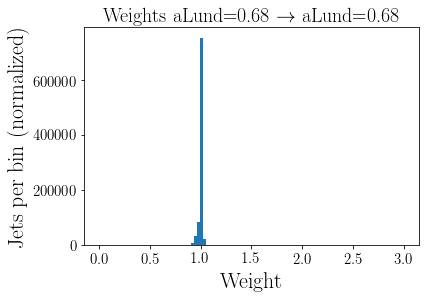

In [14]:
clip_val = 3
bins = np.linspace(0, clip_val, 101)
plt.hist(np.clip(weights_0, 0, clip_val), bins = bins)
plt.xlabel("Weight")
plt.ylabel('Jets per bin (normalized)')
plt.title("Weights " + label_0 + r' $\rightarrow$ ' + label_0, fontsize=20)
plt.show()

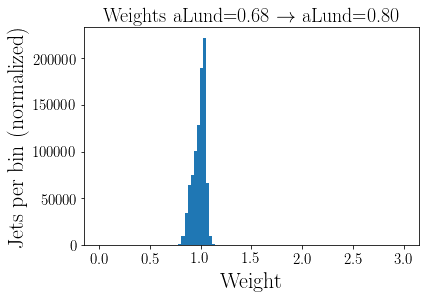

In [15]:
clip_val = 3
bins = np.linspace(0, clip_val, 101)
plt.hist(np.clip(weights_1, 0, clip_val), bins = bins)
plt.xlabel("Weight")
plt.ylabel('Jets per bin (normalized)')
plt.title("Weights " + label_0 + r' $\rightarrow$ ' + label_1, fontsize=20)
plt.show()

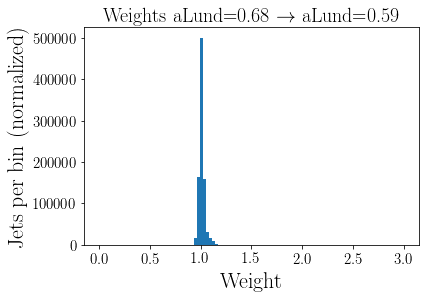

In [16]:
clip_val = 3
bins = np.linspace(0, clip_val, 101)
plt.hist(np.clip(weights_2, 0, clip_val), bins = bins)
plt.xlabel("Weight")
plt.ylabel('Jets per bin (normalized)')
plt.title("Weights " + label_0 + r' $\rightarrow$ ' + label_2, fontsize=20)
plt.show()

# Validation Plots

In [17]:
# Define default plot styles
plot_style_0 = {'histtype':'step', 'color':'black', 'linewidth':2, 'linestyle':'--', 'density':True}
plot_style_1 = {'alpha':0.5, 'density':True}

## Multiplicity

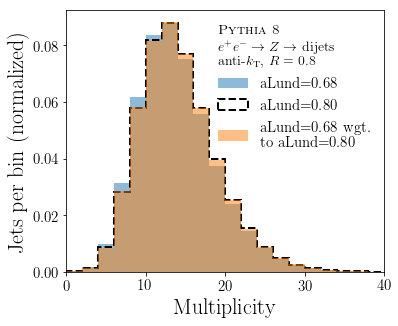

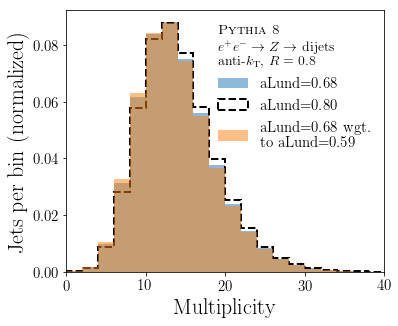

In [18]:
plt.figure(figsize=(6,5))
bins = np.linspace(0,40,21)
hist0 = plt.hist(test_dataset_0['multiplicity'], bins = bins, label = label_0, **plot_style_1)
hist1 = plt.hist(test_dataset_1['multiplicity'], bins = bins, label = label_1, **plot_style_0)
hist2 = plt.hist(test_dataset_0['multiplicity'], bins = bins, label = label_0 + ' wgt.\nto ' + label_1, weights=weights_1, **plot_style_1)

plt.xlabel('Multiplicity')
plt.ylabel('Jets per bin (normalized)')
plt.xlim([0,40])
make_legend()
plt.show()

plt.figure(figsize=(6,5))
bins = np.linspace(0,40,21)
hist0 = plt.hist(test_dataset_0['multiplicity'], bins = bins, label = label_0, **plot_style_1)
hist1 = plt.hist(test_dataset_1['multiplicity'], bins = bins, label = label_1, **plot_style_0)
hist2 = plt.hist(test_dataset_0['multiplicity'], bins = bins, label = label_0 + ' wgt.\nto ' + label_2, weights=weights_2, **plot_style_1)

plt.xlabel('Multiplicity')
plt.ylabel('Jets per bin (normalized)')
plt.xlim([0,40])
make_legend()
plt.show()

## Nsubjettiness

### tau21

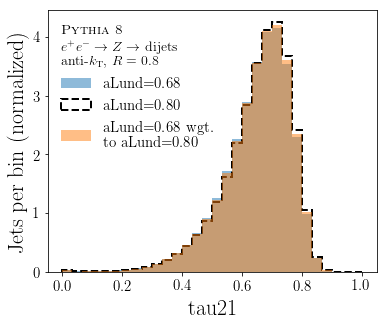

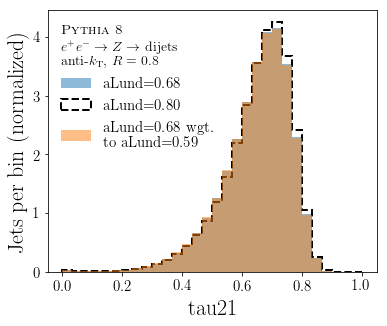

In [19]:
plt.figure(figsize=(6,5))
bins = np.linspace(0,1,31)
hist0 = plt.hist(test_dataset_0['tau21'], bins=bins, label=label_0, **plot_style_1)
hist1 = plt.hist(test_dataset_1['tau21'], bins=bins, label=label_1, **plot_style_0)
hist2 = plt.hist(test_dataset_0['tau21'], bins = bins, label = label_0 + ' wgt.\nto ' + label_1, weights=weights_1, **plot_style_1)

plt.xlabel('tau21')
plt.ylabel('Jets per bin (normalized)')
make_legend()
plt.show()

plt.figure(figsize=(6,5))
bins = np.linspace(0,1,31)
hist0 = plt.hist(test_dataset_0['tau21'], bins=bins, label=label_0, **plot_style_1)
hist1 = plt.hist(test_dataset_1['tau21'], bins=bins, label=label_1, **plot_style_0)
hist2 = plt.hist(test_dataset_0['tau21'], bins = bins, label = label_0 + ' wgt.\nto ' + label_2, weights=weights_2, **plot_style_1)

plt.xlabel('tau21')
plt.ylabel('Jets per bin (normalized)')
make_legend()
plt.show()

### tau32

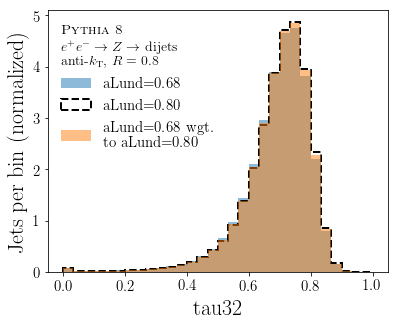

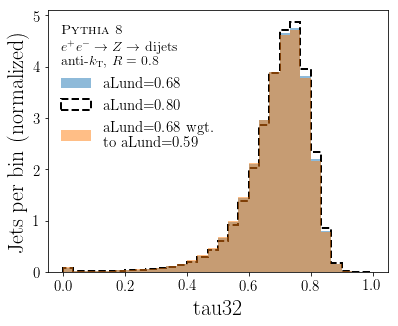

In [20]:
plt.figure(figsize=(6,5))
bins = np.linspace(0,1,31)
hist0 = plt.hist(test_dataset_0['tau32'], bins=bins, label=label_0, **plot_style_1)
hist1 = plt.hist(test_dataset_1['tau32'], bins=bins, label=label_1, **plot_style_0)
hist2 = plt.hist(test_dataset_0['tau32'], bins = bins, label = label_0 + ' wgt.\nto ' + label_1, weights=weights_1, **plot_style_1)

plt.xlabel('tau32')
plt.ylabel('Jets per bin (normalized)')
make_legend()
plt.show()

plt.figure(figsize=(6,5))
bins = np.linspace(0,1,31)
hist0 = plt.hist(test_dataset_0['tau32'], bins=bins, label=label_0, **plot_style_1)
hist1 = plt.hist(test_dataset_1['tau32'], bins=bins, label=label_1, **plot_style_0)
hist2 = plt.hist(test_dataset_0['tau32'], bins = bins, label = label_0 + ' wgt.\nto ' + label_2, weights=weights_2, **plot_style_1)

plt.xlabel('tau32')
plt.ylabel('Jets per bin (normalized)')
make_legend()
plt.show()

## ECF

### N=3, $\beta$=4

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


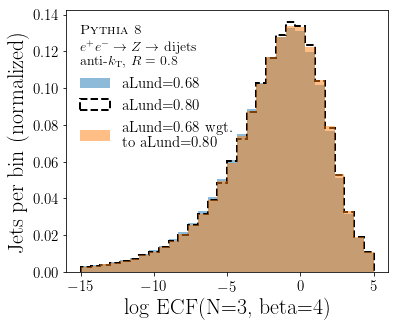

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


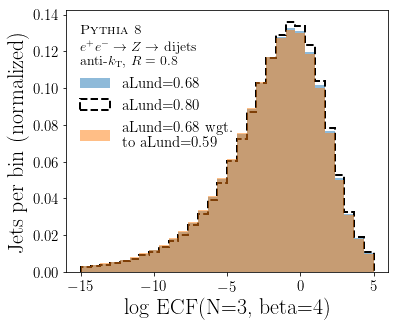

In [21]:
plt.figure(figsize=(6,5))
bins = np.linspace(-15,5,31)
hist1 = plt.hist(np.log(test_dataset_0['ECF_N3_B4']), bins=bins, label=label_0, **plot_style_1)
hist2 = plt.hist(np.log(test_dataset_1['ECF_N3_B4']), bins=bins, label=label_1, **plot_style_0)
hist3 = plt.hist(np.log(test_dataset_0['ECF_N3_B4']), bins=bins, label=label_0 + ' wgt.\nto ' + label_1, weights=weights_1, **plot_style_1)

plt.xlabel('log ECF(N=3, beta=4)')
plt.ylabel('Jets per bin (normalized)')
make_legend()
plt.show()

plt.figure(figsize=(6,5))
bins = np.linspace(-15,5,31)
hist1 = plt.hist(np.log(test_dataset_0['ECF_N3_B4']), bins=bins, label=label_0, **plot_style_1)
hist2 = plt.hist(np.log(test_dataset_1['ECF_N3_B4']), bins=bins, label=label_1, **plot_style_0)
hist3 = plt.hist(np.log(test_dataset_0['ECF_N3_B4']), bins=bins, label=label_0 + ' wgt.\nto ' + label_2, weights=weights_2, **plot_style_1)

plt.xlabel('log ECF(N=3, beta=4)')
plt.ylabel('Jets per bin (normalized)')
make_legend()
plt.show()

### N=4, $\beta$=4

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


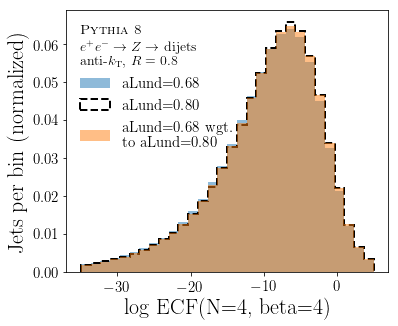

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


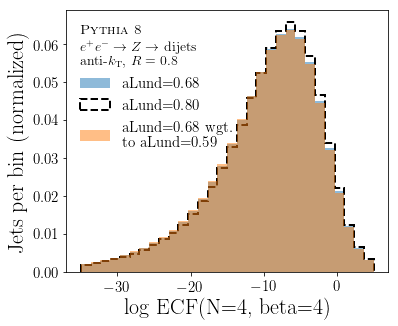

In [22]:
plt.figure(figsize=(6,5))
bins = np.linspace(-35,5,31)
hist1 = plt.hist(np.log(test_dataset_0['ECF_N4_B4']), bins=bins, label=label_0, **plot_style_1)
hist2 = plt.hist(np.log(test_dataset_1['ECF_N4_B4']), bins=bins, label=label_1, **plot_style_0)
hist3 = plt.hist(np.log(test_dataset_0['ECF_N4_B4']), bins=bins, label=label_0 +' wgt.\nto ' + label_1,  weights= weights_1, **plot_style_1)

plt.xlabel('log ECF(N=4, beta=4)')
plt.ylabel('Jets per bin (normalized)')
make_legend()
plt.show()

plt.figure(figsize=(6,5))
bins = np.linspace(-35,5,31)
hist1 = plt.hist(np.log(test_dataset_0['ECF_N4_B4']), bins=bins, label=label_0, **plot_style_1)
hist2 = plt.hist(np.log(test_dataset_1['ECF_N4_B4']), bins=bins, label=label_1, **plot_style_0)
hist3 = plt.hist(np.log(test_dataset_0['ECF_N4_B4']), bins=bins, label=label_0 +' wgt.\nto ' + label_2,  weights= weights_2, **plot_style_1)

plt.xlabel('log ECF(N=4, beta=4)')
plt.ylabel('Jets per bin (normalized)')
make_legend()
plt.show()

## Kaons

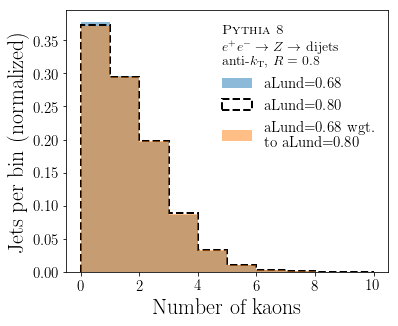

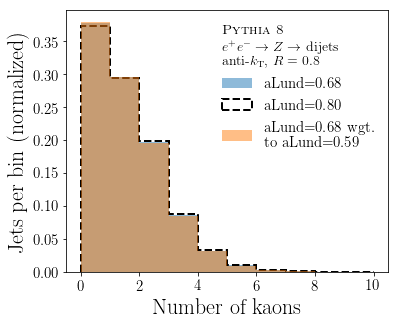

In [23]:
plt.figure(figsize=(6,5))
bins = np.linspace(0,10,11)
hist0 = plt.hist(test_dataset_0['number_of_kaons'], bins=bins, label=label_0, **plot_style_1)
hist1 = plt.hist(test_dataset_1['number_of_kaons'], bins=bins, label=label_1, **plot_style_0)
hist2 = plt.hist(test_dataset_0['number_of_kaons'], bins=bins, label=label_0 +' wgt.\nto ' + label_1,  weights= weights_1, **plot_style_1)

plt.xlabel('Number of kaons')
plt.ylabel('Jets per bin (normalized)')
make_legend()
plt.show()

plt.figure(figsize=(6,5))
bins = np.linspace(0,10,11)
hist0 = plt.hist(test_dataset_0['number_of_kaons'], bins=bins, label=label_0, **plot_style_1)
hist1 = plt.hist(test_dataset_1['number_of_kaons'], bins=bins, label=label_1, **plot_style_0)
hist2 = plt.hist(test_dataset_0['number_of_kaons'], bins=bins, label=label_0 +' wgt.\nto ' + label_2,  weights= weights_2, **plot_style_1)

plt.xlabel('Number of kaons')
plt.ylabel('Jets per bin (normalized)')
make_legend()
plt.show()

## We have shown that the reweighting method used in training (DCTR_1D_aLUND_ALTFIT.ipynb) is successful, and reweighting to the truth value rather than the incorrect fit value yields distributions closer to truth for the observable.